<a href="https://colab.research.google.com/github/ekourkchi/incNET-data/blob/master/Weather_george.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install george
!pip install corner
!pip install emcee

     |████████████████████████████████| 1.8MB 3.3MB/s 
     |████████████████████████████████| 296kB 16.6MB/s 
  ERROR: Failed building wheel for george
  Running setup.py clean for george
Failed to build george
    Running setup.py install for george ... done
     |████████████████████████████████| 51kB 1.9MB/s 


In [ ]:
import sys
import time
import os
import subprocess
import math
import matplotlib.pyplot as plt
import numpy as np
from astropy.table import Table, Column 
from scipy.stats import linregress
from scipy import interpolate
from scipy import polyval, polyfit
from scipy import odr
import pylab as py
from matplotlib import gridspec
import sklearn.datasets as ds
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import corner
import emcee
import scipy.optimize as op
from scipy.linalg import cholesky, inv,det
from scipy.optimize import minimize
import george
from george import kernels
import pandas as pd
from datetime import datetime
import time

In [ ]:
data = pd.read_excel('/content/drive/My Drive/50136-Mohe.xlsx')

for col in data.columns:
  newcol = col.split("(")[0]
  data.rename(columns={col:newcol}, inplace=True)

data.set_index("TIMESTAMP", inplace=True)

data = data.resample("1d").mean().ffill()


# data[data["ET0"].isna()]

data.head()

,DOY,T,VPD,gamma,Delta,U,Rn,ET0
TIMESTAMP,,,,,,,,
1990-01-01,1.0,-26.7,0.008393,0.067381,4.799076,1.8,3.098325,1.236897
1990-01-02,2.0,-33.2,0.006802,0.067381,4.935265,0.0,3.149681,1.267761
1990-01-03,3.0,-33.5,0.005730,0.067381,4.941713,0.0,3.172246,1.276866
1990-01-04,4.0,-31.8,0.002196,0.067381,4.905367,0.0,1.194855,0.480895
1990-01-05,5.0,-22.9,0.026560,0.067381,4.722477,1.8,3.223596,1.288056


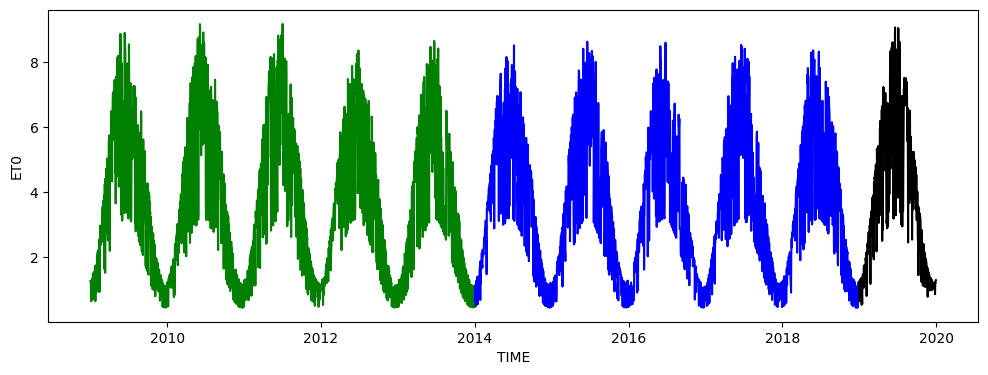

In [ ]:
fig = py.figure(figsize=(10, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

subData = data.loc["2009":"2013-12-31"]
N = len(subData)
x = subData.index
y = subData["ET0"]
ax.plot(x, y, color='green')


ax.set_xlabel("TIME")
ax.set_ylabel("ET0")


subData_cross = data.loc["2014":"2018-12-31"]
N_cross = len(subData_cross)
x_cross = subData_cross.index
y_cross = subData_cross["ET0"]
ax.plot(x_cross, y_cross, color='blue')

subData_test = data.loc["2019":]
N_test = len(subData_test)
x_test = subData_test.index
y_test = subData_test["ET0"]
ax.plot(x_test, y_test, color='black')


In [ ]:
nDelay = 8

N = len(y)
XS = np.zeros((N-nDelay, nDelay))
ys = np.zeros(N-nDelay)
for i in range(0, N-nDelay):
  XS[i,:] =  y[i:i+nDelay]
  ys[i] = y[i+nDelay]


N_cross = len(y_cross)
XS_cross = np.zeros((N_cross-nDelay, nDelay))
ys_cross = np.zeros(N_cross-nDelay)
for i in range(0, N_cross-nDelay):
  XS_cross[i,:] =  y_cross[i:i+nDelay]
  ys_cross[i] = y_cross[i+nDelay]



In [ ]:
def nll_fn2(y, y_cross, nDelay = 8):
    
    N = len(y)
    XS = np.zeros((N-nDelay, nDelay))
    ys = np.zeros(N-nDelay)
    for i in range(0, N-nDelay):
      XS[i,:] =  y[i:i+nDelay]
      ys[i] = y[i+nDelay]

    N_cross = len(y_cross)
    XS_cross = np.zeros((N_cross-nDelay, nDelay))
    ys_cross = np.zeros(N_cross-nDelay)
    for i in range(0, N_cross-nDelay):
      XS_cross[i,:] =  y_cross[i:i+nDelay]
      ys_cross[i] = y_cross[i+nDelay]

    def step(theta):
        
        sigma = np.exp(theta[0])
        L = np.exp(theta[1:nDelay+1])#*np.ones(nDelay)
 
        yerr = 0.1 #np.exp(theta[nDelay+1])

        XS2 = XS**2
        XS3 = XS**3
        yp_model = XS.dot(theta[nDelay+1: nDelay+1+nDelay])
        # yp_model += XS2.dot(theta[nDelay+2+nDelay: nDelay+2+nDelay+nDelay])
        # yp_model += XS3.dot(theta[nDelay+2+nDelay+nDelay: nDelay+2+nDelay+nDelay+nDelay])
        
        # kernel = sigma * kernels.ExpSquaredKernel(L, ndim=nDelay, axes=range(nDelay))
        
        constant = theta[nDelay+1+nDelay]
        kernel = sigma * kernels.Matern32Kernel(L, ndim=nDelay, axes=range(nDelay)) + george.kernels.ConstantKernel(constant, ndim=nDelay)
        
        gp = george.GP(kernel)
        gp.compute(XS, yerr)


        PRED_cross = gp.predict(ys-yp_model, XS_cross, return_var=True) 
        ys_cross_pred = PRED_cross[0] + XS_cross.dot(theta[nDelay+1: nDelay+1+nDelay])

        PRED = gp.predict(ys-yp_model, XS, return_var=True) 
        ys_pred = PRED[0] + XS.dot(theta[nDelay+1: nDelay+1+nDelay])

        ya = np.concatenate((ys, ys_cross))    # all real
        yp = np.concatenate((ys_pred, ys_cross_pred)) # all predicted

        return np.sqrt(np.mean((ya-yp)**2))


        
        #sys.exit()
        # Compute determinant via Cholesky decomposition
        # return -gp.lnlikelihood(ys-yp_model)
    return step

In [ ]:
t1 =  datetime.now()
###########################################

# Maximum Likelihood
result = minimize(nll_fn2(y, y_cross), [0.1 for i in range(nDelay*2+2)], 
               method='L-BFGS-B')
print(result)


###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

      fun: 0.7747356243711371
 hess_inv: <18x18 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 7.43849426e-07, -5.32462963e-05, -7.34967642e-06, -6.30606678e-06,
       -2.81774604e-05, -1.15574217e-05, -5.16253706e-06, -2.24598118e-05,
        1.25677246e-05,  2.88657986e-06,  5.13145082e-05,  1.24256161e-04,
        1.48503432e-04,  9.62341318e-05, -1.48769885e-05, -3.05533376e-05,
        3.35731443e-05, -7.66053887e-07])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 5149
      nit: 250
   status: 0
  success: True
        x: array([-0.34794715, -5.32422812,  5.53453865,  1.3366227 ,  1.15120037,
       -1.59265826,  1.57327926, -1.48297597, -1.52677899,  0.06677155,
        0.01496191,  0.11932816, -0.05059552,  0.06326306,  0.05845597,
        0.03503404,  0.49799151,  0.14394772])
Execution time:
2:13:48.010950


In [ ]:
def GPR(y, nDelay = 8):
    
    N = len(y)
    XS = np.zeros((N-nDelay, nDelay))
    ys = np.zeros(N-nDelay)
    for i in range(0, N-nDelay):
      XS[i,:] =  y[i:i+nDelay]
      ys[i] = y[i+nDelay]

    def step(theta):
        
        sigma = np.exp(theta[0])
        L = np.exp(theta[1:nDelay+1])#*np.ones(nDelay)
 
        yerr = 0.1 #np.exp(theta[nDelay+1])

        XS2 = XS**2
        XS3 = XS**3
        yp_model = XS.dot(theta[nDelay+1: nDelay+1+nDelay])
        # yp_model += XS2.dot(theta[nDelay+2+nDelay: nDelay+2+nDelay+nDelay])
        # yp_model += XS3.dot(theta[nDelay+2+nDelay+nDelay: nDelay+2+nDelay+nDelay+nDelay])
        
        # kernel = sigma * kernels.ExpSquaredKernel(L, ndim=nDelay, axes=range(nDelay))
        
        constant = theta[nDelay+1+nDelay]
        kernel = sigma * kernels.Matern32Kernel(L, ndim=nDelay, axes=range(nDelay)) + george.kernels.ConstantKernel(constant, ndim=nDelay)
        #Matern32Kernel
        gp = george.GP(kernel)
        gp.compute(XS, yerr)
        
        #sys.exit()
        # Compute determinant via Cholesky decompositiona
        return gp
    return step

In [ ]:
theta = result.x
result.x

array([-0.34794715, -5.32422812,  5.53453865,  1.3366227 ,  1.15120037,
       -1.59265826,  1.57327926, -1.48297597, -1.52677899,  0.06677155,
        0.01496191,  0.11932816, -0.05059552,  0.06326306,  0.05845597,
        0.03503404,  0.49799151,  0.14394772])

In [ ]:
gp = GPR(y)(result.x)

(368,)
(368, 8)


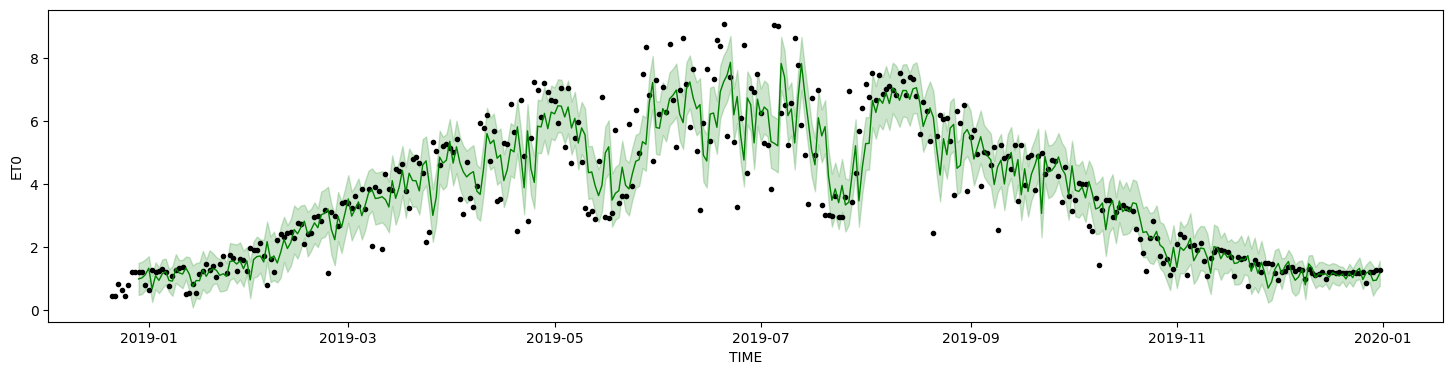

In [ ]:
fig = py.figure(figsize=(15, 4), dpi=100)    
fig.subplots_adjust(wspace=0, top=0.9, bottom=0.12, left=0.05, right=0.98)
ax = fig.add_subplot(111)

###################################################################################
subData_test = data.loc["2018-12-21":]#["2016-01-01":"2019-01-01"]
N = len(subData_test)
x_test = subData_test.index
y_test = subData_test["ET0"].values


XS_test = np.zeros((N-nDelay, nDelay))
ys_test = np.zeros(N-nDelay)
for i in range(0, N-nDelay):
  XS_test[i,:] =  y_test[i:i+nDelay]
  ys_test[i] = y_test[i+nDelay]

XS2 = XS**2
XS_test2 = XS_test**2
XS3 = XS**3
XS_test3 = XS_test**3
yp_model = XS_test.dot(theta[nDelay+2: nDelay+2+nDelay])# + XS_test2.dot(theta[nDelay+2+nDelay: nDelay+2+nDelay+nDelay]) + XS_test3.dot(theta[nDelay+2+nDelay+nDelay: nDelay+2+nDelay+nDelay+nDelay])
YP_model = XS.dot(theta[nDelay+2: nDelay+2+nDelay])# + XS2.dot(theta[nDelay+2+nDelay: nDelay+2+nDelay+nDelay]) + XS3.dot(theta[nDelay+2+nDelay+nDelay: nDelay+2+nDelay+nDelay+nDelay])

print(yp_model.shape)
print(XS_test.shape)

ax.plot(x_test, y_test, 'k.')
ax.set_xlabel("TIME")
ax.set_ylabel("ET0")

y_test_pred = gp.predict(ys-YP_model, XS_test, return_var=True)
y_pred = y_test_pred[0] + yp_model
yt_p = y_pred[:N-nDelay]
yt_var = y_test_pred[1][:N-nDelay]

xt = subData_test.iloc[nDelay:N].index

ax.plot(xt, yt_p, 'g-', linewidth=1)

ax.fill_between(xt, yt_p - np.sqrt(yt_var), yt_p + np.sqrt(yt_var),
                color="g", alpha=0.2)

###################################################################################

###################################################################################
# subData_test = data.loc["2018-12-21":]
# N = len(subData_test)
# x_test = subData_test.index
# y_test = subData_test["ET0"].values


# XS_test = np.zeros((N-nDelay, nDelay))
# ys_test = np.zeros(N-nDelay)
# for i in range(0, N-nDelay):
#   XS_test[i,:] =  y_test[i:i+nDelay]
#   ys_test[i] = y_test[i+nDelay]

# XS2 = XS**2
# XS_test2 = XS_test**2
# XS3 = XS**3
# XS_test3 = XS_test**3
# yp_model = XS_test.dot(theta[nDelay+1: nDelay+1+nDelay])# + XS_test2.dot(theta[nDelay+2+nDelay: nDelay+2+nDelay+nDelay]) + XS_test3.dot(theta[nDelay+2+nDelay+nDelay: nDelay+2+nDelay+nDelay+nDelay])
# YP_model = XS.dot(theta[nDelay+1: nDelay+1+nDelay]) #+ XS2.dot(theta[nDelay+2+nDelay: nDelay+2+nDelay+nDelay]) + XS3.dot(theta[nDelay+2+nDelay+nDelay: nDelay+2+nDelay+nDelay+nDelay])


# print(yp_model.shape)
# print(XS_test.shape)

# ax.plot(x_test, y_test, 'k.')
# ax.set_xlabel("TIME")
# ax.set_ylabel("ET0")

# y_test_pred = gp.predict(ys-YP_model, XS_test, return_var=True)
# y_pred = y_test_pred[0] + yp_model
# yt_p = y_pred[:N-nDelay]
# yt_var = y_test_pred[1][:N-nDelay]

# xt = subData_test.iloc[nDelay:N].index

# ax.plot(xt, yt_p, 'r-', linewidth=1)

# ax.fill_between(xt, yt_p - np.sqrt(yt_var), yt_p + np.sqrt(yt_var),
#                 color="r", alpha=0.2)

###################################################################################

In [ ]:

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

RMSE = mean_squared_error(ys_test, y_pred, squared=False)
R2 = r2_score(ys_test, y_pred)

print(RMSE, R2)

1.1210802500390618 0.7331728817144323


In [ ]:
def lnlike(theta, y, nDelay = 10):
    
    N = len(y)
    XS = np.zeros((N-nDelay, nDelay))
    ys = np.zeros(N-nDelay)
    for i in range(0, N-nDelay):
      XS[i,:] =  y[i:i+nDelay]
      ys[i] = y[i+nDelay]

        
    sigma = np.exp(theta[0])
    L = np.exp(theta[2])*np.ones(nDelay)

    yerr = np.exp(theta[1])
    # yerr = np.exp(theta[nDelay+1])
    
    kernel = sigma * kernels.ExpSquaredKernel(L, ndim=nDelay, axes=range(nDelay))
    gp = george.GP(kernel)
    gp.compute(XS, yerr)
    
    #sys.exit()
    # Compute determinant via Cholesky decomposition
    return gp.lnlikelihood(ys)
    

################################################################# 

def lnprior(theta):
    
    return 0.0

################################################################# 
def lnprob(theta, y, nDelay):
    
    lp = lnprior(theta)
    if not np.isfinite(lp) :
        return -np.inf    
    return lp + lnlike(theta, y, nDelay = nDelay)


In [ ]:
t1 =  datetime.now()
###########################################

ndim, nwalkers = 3, 32
p0 = [np.random.randn(ndim) for i in range(nwalkers)]

sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(y, 10))

sampler.reset()
sampler.run_mcmc(p0, 300)


###########################################
t2 =  datetime.now()
print("Execution time:")
print(t2-t1)

emcee: Exception while calling your likelihood function:
  params: [ 0.21133081  0.7598535  -0.31301715]
  args: (TIMESTAMP
2010-01-01    0.555196
2010-01-02    1.229812
2010-01-03    0.526392
2010-01-04    0.658587
2010-01-05    0.484610
                ...   
2015-12-27    1.267678
2015-12-28    1.151186
2015-12-29    1.269692
2015-12-30    0.459323
2015-12-31    0.586613
Freq: D, Name: ET0, Length: 2191, dtype: float64, 10)
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/emcee/ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-53-27d65e4e5517>", line 38, in lnprob
    return lp + lnlike(theta, y, nDelay = nDelay)
  File "<ipython-input-53-27d65e4e5517>", line 7, in lnlike
    XS[i,:] =  y[i:i+nDelay]
  File "/usr/local/lib/python3.6/dist-packages/pandas/core/series.py", line 871, in __getitem__
    result = self.index.get_value(self, key)
  File "/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/datetimes.py", line 651, in get_value
    value = Index.get_value(self, series, key)
  File "/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/base.py", line 4403, in get_value
    k = self._convert_scalar_indexer(k, kind="getitem")
  File "/usr/local/lib/python3.6/dist-packages/pandas/core/indexes/datetimelike.py", line 390, in _convert_scalar_indexer
    return super()._convert_scalar_indexer(key, kind=kin

KeyboardInterrupt: ignored

In [ ]:
samples = sampler.chain[:, 150:, :].reshape((-1, ndim))
theta = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                            zip(*np.percentile(samples, 
                            [16, 50, 84],
                            axis=0)))

truths=[t[0] for t in theta]
fig = corner.corner(samples, labels=['P'+str(n) for n in range(ndim)], 
                    truths=truths, 
                    quantiles=[0.16, 0.5, 0.84], 
                    show_titles=True, 
                    title_kwargs={"fontsize": 12}, 
                    title_fmt=".3f")
